In [74]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

import utility as util

In [35]:
args = util.AttrDict(epochs=5, print_every=100, batch_size=32)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using device: cuda:0
Files already downloaded and verified
Files already downloaded and verified


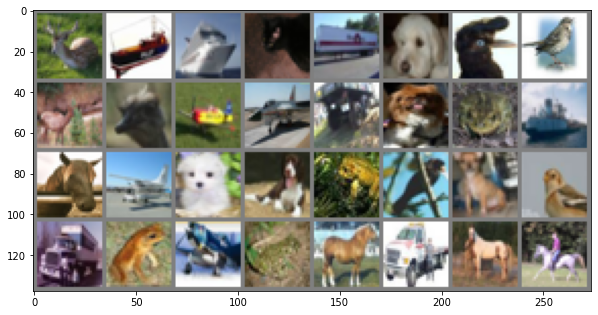

 deer  ship  ship   cat truck   dog  bird  bird  deer  bird plane plane truck   dog  frog  ship horse plane   dog   dog  frog  bird   dog  bird truck  frog plane  frog horse truck horse horse


(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [56]:
# functions to show an image
def imshow(img):
    # Un-normalize data.
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
# images has shape (batch size, num channels (3), hor width, ver height)
# labels has shape (batch size,)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(args.batch_size)))

In [37]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Accuracy: 21.81%



Accuracy: 37.68%



Accuracy: 43.41%



Accuracy: 46.74%



Accuracy: 50.55%
Done.


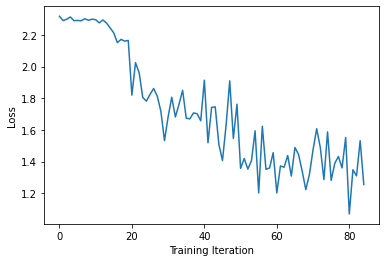

In [76]:
loss_over_time = []
def train(net, args, trainloader, testloader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for epoch in range(1, args.epochs + 1):
        prefix = f"Training Epoch {epoch}: "
        pbar = tqdm(trainloader, desc=prefix, 
                dynamic_ncols=True, leave=True, position=0)
        for iteration, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if iteration % args.print_every == 0 or iteration == len(trainloader)-1:
                pbar.set_description("Training epoch {} (loss {:9.4f}): ".format(epoch, loss.item()))
                pbar.update()
                loss_over_time.append(loss.item())
        correct = 0
        total = 0
        with torch.no_grad():
            net.eval()
            prefix = f"Evaluating: "
            for inputs, labels in tqdm(testloader, desc=prefix,
                        dynamic_ncols=True, leave=True, position=0):
                inputs, labels = inputs.to(device), labels.to(device)
                # calculate outputs by running images through the network
                outputs = net(inputs)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            net.train()
        print("Accuracy: {:1.2%}".format(correct / total))
    print("Done.")

net = Net().to(device)
should_create_new_instance = True
if should_create_new_instance:
    train(net, args, trainloader, testloader)
    torch.save(net.state_dict(), './models/cifar_net.pth')
    plt.plot(range(len(loss_over_time)), loss_over_time)
    ax = plt.gca()
    ax.set_ylabel("Loss")
    ax.set_xlabel("Training Iteration")
else:
    net.load_state_dict(torch.load('./models/cifar_net.pth'))

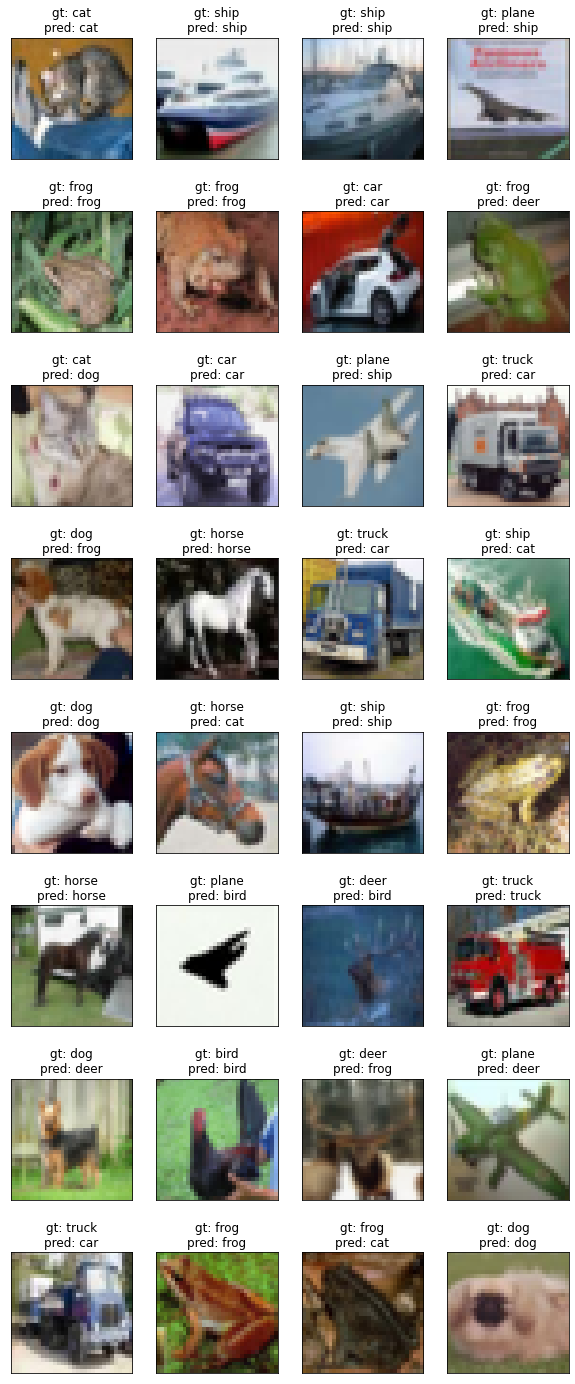

In [71]:
dataiter = iter(testloader)
images, labels = dataiter.next()

_images = images.to(device)
outputs = net(_images)
_, predicted = torch.max(outputs, 1)

# print images
# imshow(torchvision.utils.make_grid(images))
# get labels
ground_truth = [classes[labels[j]] for j in range(args.batch_size)]
predictions = [classes[predicted[j]] for j in range(args.batch_size)]

df = pd.DataFrame({
    'GroundTruth': ground_truth,
    'Prediction': predictions
})

images = images.numpy()
n_rows = args.batch_size // 4 + int((args.batch_size % 4) > 0)
fig, axes = plt.subplots(n_rows, 4, figsize=(10, 25))
axes = axes.ravel()
for idx, image in enumerate(images):
    image = image / 2 + 0.5
    image = image.transpose((1, 2, 0))
    axes[idx].imshow(image)
    title = "gt: {}\npred: {}".format(df.at[idx, 'GroundTruth'], df.at[idx, 'Prediction'])
    axes[idx].set_title(title)
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

In [75]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    net.eval()
    prefix = f"Evaluating: "
    for images, labels in tqdm(testloader, desc=prefix,
                dynamic_ncols=True, leave=True, position=0):
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    net.train()


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))


Accuracy for class plane is: 37.5 %
Accuracy for class car   is: 67.8 %
Accuracy for class bird  is: 26.9 %
Accuracy for class cat   is: 50.3 %
Accuracy for class deer  is: 47.6 %
Accuracy for class dog   is: 50.7 %
Accuracy for class frog  is: 49.3 %
Accuracy for class horse is: 47.0 %
Accuracy for class ship  is: 69.2 %
Accuracy for class truck is: 33.3 %
